# Bayesian Inference

We will use two scenarios to walk through the steps of a data science project relying on bayesian inference.

**Scenario A**: our ecommerce shop sends an ad to its clients. Based on the few data collected, what can we say about the convergence rate of the add?

**Scenario B**: our ecommerce shop sends an ad to some clients clients, and another one to other clients. Based on the few data collected, which add seems to do better? 

### Ingredients

Bayesian data analysis needs:
- data: in this case the number of customers signing up after seeing the proposed add.
- a generative model: in this case the only parameter that the model needs is the sign up probability, which can be modeled as a binomial distribution.
- prior information: to infer the parameter from the data, we need to consider a range of possible parameter values. In this case, the only prior information we have is that the probability of signup can range between 0 and 1, so a natural choice is to represent prior information with a uniform distribution

### Recipe

A typical bayesian inference approach consists in:
1. run a large number of simulations where a possible parameter value is drawn from the prior and used to simulate the process that generated the original dataset
2. answer the question "Which parameter value gave me simulated data that were very similar to the original data?"



In [1]:
### SCENARIO A

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Number of random draws from the prior
n_draws = 100000

# Ingredient 1: we use a uniform prior and sample n_draws draws from a uniform prior 
prior = pd.Series(np.random.uniform(0, 1, size = n_draws ))
ax = prior.hist(weights = np.ones_like(prior)/float(len(prior)))
ax.set_xlabel('Prior on the rate of signups')
ax.set_ylabel('Probability')
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
# Ingredient 2: Let's now define the generative model
def generative_model(parameters):
    signups = np.random.binomial(parameters[0], parameters[1]) # returns number of successes
    return(signups)

# for instance, let's simulate 3 times sending the ad to 20 people, with a signup rate of 0.1
for i in np.arange(3):
    print(generative_model([20, 0.1]))

3
4
3


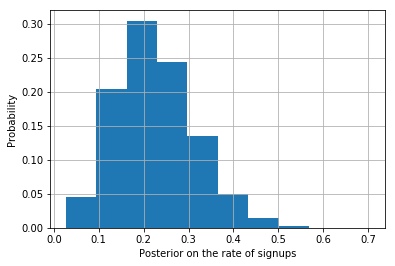

In [3]:
# Ingredient 3: the actual data
N_participants = 20
N_signups = 4

# Now we are ready to simulate the testing campaing as much as we want!
sim_data = list()
for p in prior:
    sim_data.append(generative_model([ N_participants, p]))
                    
# Next, we keep only the draws (and associated parameter) that match the observed data
posterior = pd.Series(
    [prior[idx] for idx in range(len(sim_data)) if sim_data[idx] == N_signups])

# eyeball the posterior
ax = posterior.hist(weights = np.ones_like(posterior)/float(len(posterior)))
ax.set_xlabel('Posterior on the rate of signups')
ax.set_ylabel('Probability')
plt.show()

In [4]:
# it is common sense to check that we got enought draws left after the filtering. 
# it appears a safe number here could be something like >1000.
print('Number of draws used to create the posterior: %.0f' % len(posterior))

# Some summary statistics
print('Posterior median: %.3f, Posterior quantile interval: %.3f-%.3f' % 
      (posterior.median(), posterior.quantile(.025), posterior.quantile(.975)))


Number of draws used to create the posterior: 4755
Posterior median: 0.217, Posterior quantile interval: 0.078-0.416


### Comparing to a baseline
Imagine now, that we want to know if this ad has a signup rate higher than 15%.
This can be done very simply by integrating over the posterior from 0.15 to 1:

In [5]:
p_signup_rate_higer_than_15pc = len(posterior[posterior > 0.15]) / len(posterior)
print('Based on the collected date, we estiamte a %.2f%%  probability that the ad has a conversion rate higher than 15%%.'  % (100 * p_signup_rate_higer_than_15pc))

Based on the collected date, we estiamte a 79.81%  probability that the ad has a conversion rate higher than 15%.


### Making predictions
Imagine now, that we would like to estimate how the ad would perform if it were presented to 100 people. 
Again, the answer will come in the form of a probability distribution.


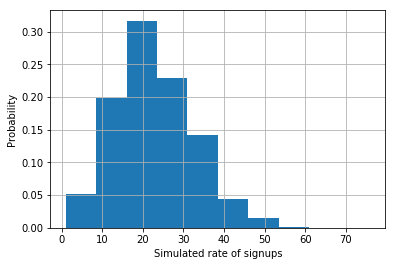

Sign-up 95% quantile interval 7-43


In [6]:
predicted_signups = pd.Series([generative_model([100, p]) for p in posterior])

ax = predicted_signups.hist(weights = np.ones_like(predicted_signups)/float(len(predicted_signups)))
ax.set_xlabel('Simulated rate of signups')
ax.set_ylabel('Probability')
plt.show()

print('Sign-up 95%% quantile interval %d-%d' % tuple(predicted_signups.quantile([.025, .975]).values))

### Incorporating available knowledge
Now let's imagine that an "expert" told us that convergence rate is usually between 5 and 20%.

This information could be very valuable, and bring some extra money to the business. How can we incorporate it in the model?

One natural way would be to change the prior, from the uninformative uniform distribution to a distribution that better fits the opinion of the expert.



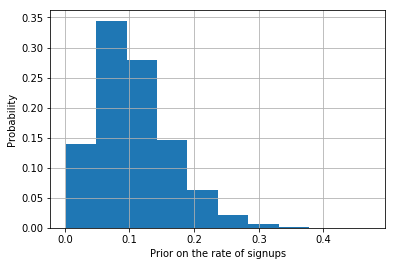

In [7]:
# prior
prior = pd.Series(np.random.beta(3, 25, size = n_draws ))

ax = prior.hist(weights = np.ones_like(prior)/float(len(prior)))
ax.set_xlabel('Prior on the rate of signups')
ax.set_ylabel('Probability')
plt.show()

# In general, the more data we have the less the prior is affecting the output. 
# But beware of making too lose statements, as they can really affect the outcome when datasets are of smaller sizes (as uit is tipically the case)


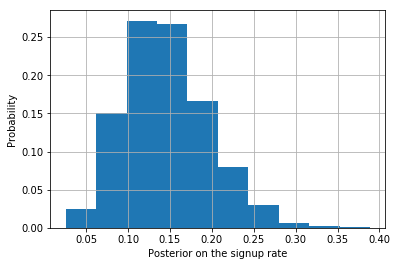

In [8]:
# the rest of the analysis is simply a copy-paste from the previous one

sim_data = list()
for p in prior:
    sim_data.append(generative_model([ N_participants, p]))
                    
#keep only the draws matching the observed data
posterior = pd.Series(
    [prior[idx] for idx in range(len(sim_data)) if sim_data[idx] == N_signups])

# eyeball the posterior
ax = posterior.hist(weights = np.ones_like(posterior)/float(len(posterior)))
ax.set_xlabel('Posterior on the signup rate')
ax.set_ylabel('Probability')
plt.show()


## SCENARIO B
Here we will tackle the case where we want to compare 2 different ads to see which one performs better.

Again, we can reuse a large portion of the previous code. Indeed, the model and the prior remain the same, and we simply need to add the new data.


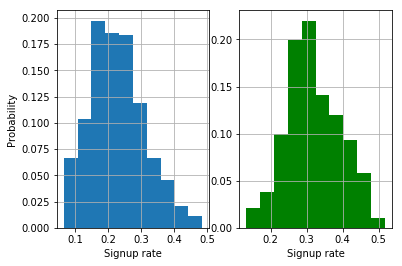

Median signup rate for ad A: 0.223 
Median signup rate for ad B: 0.312


In [9]:
# even though most of the elements were already coded in the cells above, let's report them in this cell too for completeness.

#--- Ingredients

# Prior
n_draws = 10000
prior_A = pd.Series(np.random.uniform(0, 1, size = n_draws )) # uniform
prior_B = pd.Series(np.random.uniform(0, 1, size = n_draws )) # uniform

# Model
def generative_model(parameters):
    signups = np.random.binomial(parameters[0], parameters[1]) # returns number of successes
    return(signups)

# Data
N_participants_A = 20
N_participants_B = 35
N_signups_A = 4
N_signups_B = 11

#--------


#--- Recipe

# Simulate
sim_data_A = list()
sim_data_B = list()

for idx in range(len(prior_A)):
    sim_data_A.append(generative_model([ N_participants_A, prior_A[idx]]))
    sim_data_B.append(generative_model([ N_participants_B, prior_B[idx]]))

# Compute the posterior
posterior_A = pd.Series([prior_A[idx] for idx in range(len(sim_data_A)) if sim_data_A[idx] == N_signups_A])
posterior_B = pd.Series([prior_B[idx] for idx in range(len(sim_data_B)) if sim_data_B[idx] == N_signups_B])

# --------


# --- Plot the results
#subplot(A, B)

fig = plt.figure()
fig.add_subplot(1, 2, 1)
ax1 = posterior_A.hist(weights = np.ones_like(posterior_A)/float(len(posterior_A)))
ax1.set_xlabel('Signup rate')
ax1.set_ylabel('Probability')
fig.add_subplot(1, 2, 2)
ax2 = posterior_B.hist(weights = np.ones_like(posterior_B)/float(len(posterior_B)), color = 'green')
ax2.set_xlabel('Signup rate')
plt.show()

# Some summary statistics
print('Median signup rate for ad A: %.3f \nMedian signup rate for ad B: %.3f' % 
      (posterior_A.median(), posterior_B.median()))

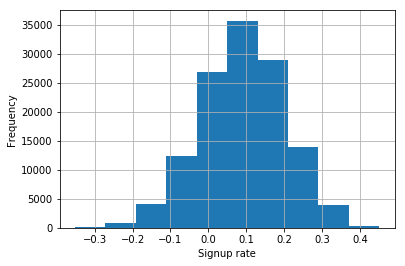

Based on the collected data, we estiamte a 79.55%  probability that the ad B has a conversion rate higher than the ad A.


In [10]:
# Now that we have the estimated signup rates for both A and B, we can answer the question of which one has a higher signup rate (in a probabilistic way of course!!)

diff_rate = pd.Series([float(pB - pA) for pA in posterior_A for pB in posterior_B])
# for some python reason the simple diff_rate = posterior_B - posterior_A works but gives many nans...

ax1 = diff_rate.hist()
ax1.set_xlabel('Signup rate')
ax1.set_ylabel('Frequency')
plt.show()

# As we did before when comparing to a baseline, we can now calculate the probability that signup rate is higher for B:
p_signup_rate_higer_for_B = len(diff_rate[diff_rate>0])/ len(diff_rate)

print('Based on the collected data, we estiamte a %.2f%%  probability that the ad B has a conversion rate higher than the ad A.'  % (100 * p_signup_rate_higer_for_B))

### Next steps
A great improvement now would be to use a library for bayesian computations called Stan. This is a faster and less error prone approach than the one we used for scenario A (called approximate bayesian computation), where things were coded from scratch. One of the key features that make stan faster is that the likelihood of the model is calculated, instead of simulated via sampling (very time consuming).

Stan is a programming language for bayesian modelling, and it can nicely interface with python and other popular data science languages. Here is a useful cheatsheet: http://www.sumsar.net/files/posts/2017-bayesian-tutorial-exercises/stan_cheat_sheet2.12.pdf. Again, thanks to Rasmus Baath for the excelent material and explanation.

 